In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import squarify

from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient
from textwrap import wrap

### Parâmetros do matplot e Seaborn

In [4]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

### Recuperação de Datasets do MongoDB

In [5]:
df_tipos_infracoes_2018 = mongo_to_dataframe("tipos_infracoes_2018")

In [51]:
df_acidentes_fatais_2008_2017 = mongo_to_dataframe("acidentes_fatais_2008_2017")

In [46]:
df_pedestres_mortos_trechos_ns_2008_2017 = mongo_to_dataframe("pedestres_mortos_trechos_ns_2008_2017")

In [7]:
df_acidentes_rodovias_2010_2019 = mongo_to_dataframe("acidentes_rodovias_2010_2019")

In [44]:
df_frota_veiculos_2009_2019 = mongo_to_dataframe("frota_veiculos_2009_2019")

In [49]:
df_numero_habilitados_2009_2018 = mongo_to_dataframe("numero_habilitados_2009_2018")

In [5]:
df_infracoes_prf_2010_2018 = mongo_to_dataframe("infracoes_prf_2010_2018")

In [18]:
df_demografia_2015_2016 = mongo_to_dataframe("demografia_brasilia_2015_2016")

In [58]:
df_infracoes_der_2018_2019 = mongo_to_dataframe("infracoes_der_2018_2019")

In [51]:
df_indice_mortos_transito_2009_2010 = mongo_to_dataframe("indice_mortos_transito_2009_2018")

In [22]:
df_sinalizacao_2018 = mongo_to_dataframe("sinalizacao_2018")

In [125]:
df_equipamentos_fiscalizacao_2018 = mongo_to_dataframe("equipamentos_fiscalizacao_2018")

In [118]:
df_faixas_por_ra_2018 = mongo_to_dataframe("faixas_por_ra_2018")

In [52]:
df_condicoes_rodovias_2018 = mongo_to_dataframe("condicoes_rodovias_2018")

## Análise da relação da distribuição de acidentes graves de trânsito nas regiões administrativas do DF

### Observações

* Comparando o número das populações das cidades com mais acidentes é possível determinar que o tamanho da população está diretamente relacionado com o número de acidentes fatais
* A correlação de pearson mostra uma relação forte, positiva de inclinação 0.92
* O rank das cidades com maiores populações é quase o mesmo das cidades com maior número de acidentes
* A correlação entre o número de acidentes fatais em uma região e sua renda per capita é média e negativa, indicando uma possível proporção inversa (Regiões com rendas maiores tem população menor)
* As correlações mais fortes são diretamente com o número da população, visto que as correlações entre densidade e acidentes são irrelevantes.

In [4]:
df_demografia_2015_2016.head()

,RA,População 2013,População 2015/2016,TMGCA (%),Área com Ocupação Urbana (em ha),Densidade Urbana 2015,Área Total da RA (em ha),Densidade Demográfica 2015,Casas (%),Apart + Quit (%),Distância do Centro (Plano Piloto) em Km,Grupo de Renda,Renda Per Capita 2015
0,RA XXIII - Varjão,9292,8453,-4.62,59.42,142.27,75.56,111.87,75.75,20.44,11,Baixa,627.81
1,RA XIX - Candangolândia,16886,15641,-3.76,113.85,137.38,662.70,23.60,87.20,12.00,11,Média Baixa Renda,1460.98
2,RA IX - Ceilândia,451872,479713,3.03,3691.92,129.94,23401.14,20.50,94.36,4.25,26,Média Baixa Renda,914.61
3,RA XV - Recanto das Emas,138997,146906,2.81,1246.27,117.88,10261.11,14.32,96.98,2.76,26,Média Baixa Renda,803.92
4,RA XIV - São Sebastião,98908,99525,0.31,882.69,112.75,35571.37,2.80,92.71,6.61,26,Média Baixa Renda,966.96


In [5]:
df_demografia_2015_2016 = df_demografia_2015_2016[df_demografia_2015_2016['RA'] != 'DISTRITO FEDERAL - DF']

In [26]:
cidades_mais_populosas = df_demografia_2015_2016.sort_values('População 2015/2016', ascending = False)
cidades_mais_populosas.head(n = 7)

,RA,População 2013,População 2015/2016,TMGCA (%),Área com Ocupação Urbana (em ha),Densidade Urbana 2015,Área Total da RA (em ha),Densidade Demográfica 2015,Casas (%),Apart + Quit (%),Distância do Centro (Plano Piloto) em Km,Grupo de Renda,Renda Per Capita 2015
2,RA IX - Ceilândia,451872,479713,3.03,3691.92,129.94,23401.14,20.50,94.36,4.25,26,Média Baixa Renda,914.61
7,RA XII - Samambaia,228356,258457,6.39,2501.67,103.31,10125.85,25.52,89.29,10.49,25,Média Baixa Renda,914.75
25,RA I - Plano Piloto,216489,210067,-1.49,10176.75,20.64,40989.31,5.12,9.19,90.45,0,Alta,5559.75
14,RA III - Taguatinga,212863,207045,-1.38,2572.11,80.50,8056.15,25.70,69.73,30.00,21,Média Alta Renda,1998.14
18,RA VI - Planaltina,185375,190495,1.37,2989.46,63.72,153847.95,1.24,94.49,4.86,38,Média Baixa Renda,933.8
3,RA XV - Recanto das Emas,138997,146906,2.81,1246.27,117.88,10261.11,14.32,96.98,2.76,26,Média Baixa Renda,803.92
17,RA XX - Águas Claras,118864,138562,7.97,1937.03,71.53,2285.82,60.62,23.06,76.84,19,Média Alta Renda,3339.91


Text(0.5, 1.0, 'Treemap das regiões mais populosas do DF')

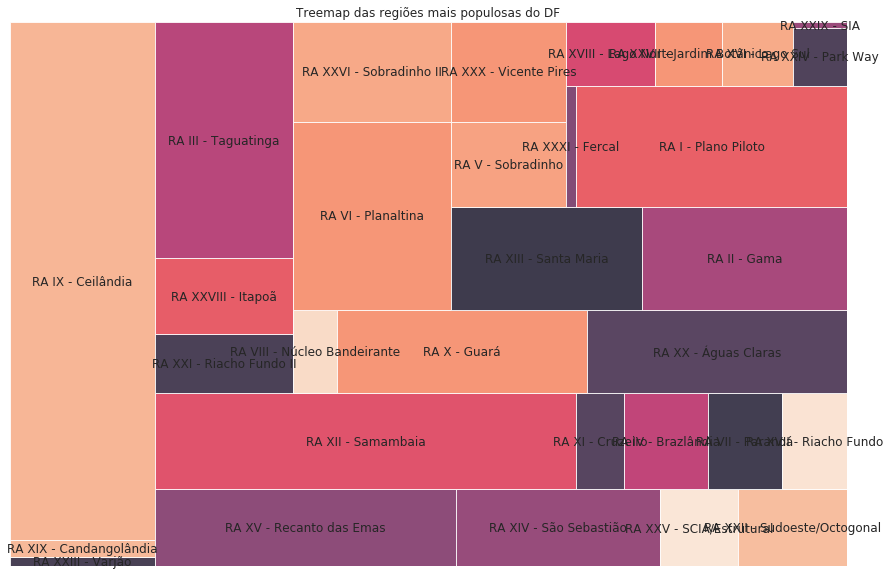

In [63]:
squarify.plot(sizes = df_demografia_2015_2016['População 2015/2016'], label = df_demografia_2015_2016['RA'], alpha = .8 )
plt.rcParams['figure.figsize'] = [15, 10]
plt.axis('off')
plt.title('Treemap das regiões mais populosas do DF')

In [ ]:
df_acidentes_fatais_2008_2017 = df_acidentes_fatais_2008_2017[df_acidentes_fatais_2008_2017['Ano'] == '2016']

In [114]:
def pearson_corr_demografia_acidentes(atributo_demografia):
    acidentes_fatais_por_regiao = df_acidentes_fatais_2008_2017.groupby('Região Administrativa').size().reset_index(name = 'contagem')
    acidentes_fatais_por_regiao = acidentes_fatais_por_regiao.sort_values('contagem', ascending = False)
    
    df_demografia = df_demografia_2015_2016[['RA', atributo_demografia]]
    cidades = df_demografia.RA.str.split(' - ', n = 1, expand = True)
    df_demografia.RA = cidades[1]
    df_demografia.RA = df_demografia.RA.str.upper()
    
    atributo_por_populacao = pd.merge(acidentes_fatais_por_regiao, df_demografia, left_on = 'Região Administrativa', right_on = 'RA')
    
    if atributo_demografia == 'População 2015/2016':
        correlacao_atributo_por_populacao = atributo_por_populacao['contagem'].corr(atributo_por_populacao[atributo_demografia])
    else:
        correlacao_atributo_por_populacao = atributo_por_populacao['contagem'].corr(atributo_por_populacao[atributo_demografia].astype(int))
        atributo_por_populacao[atributo_demografia] = atributo_por_populacao[atributo_demografia].astype(int)
    
    
    print('Valor da correlação: {}'.format(correlacao_atributo_por_populacao))
    sns.regplot(x = 'contagem', y = atributo_demografia, data = atributo_por_populacao, fit_reg = True)
    plt.title("Correlação entre número de acidentes fatais e " + atributo_demografia)
    plt.show()
    

Valor da correlação: 0.914795382608649


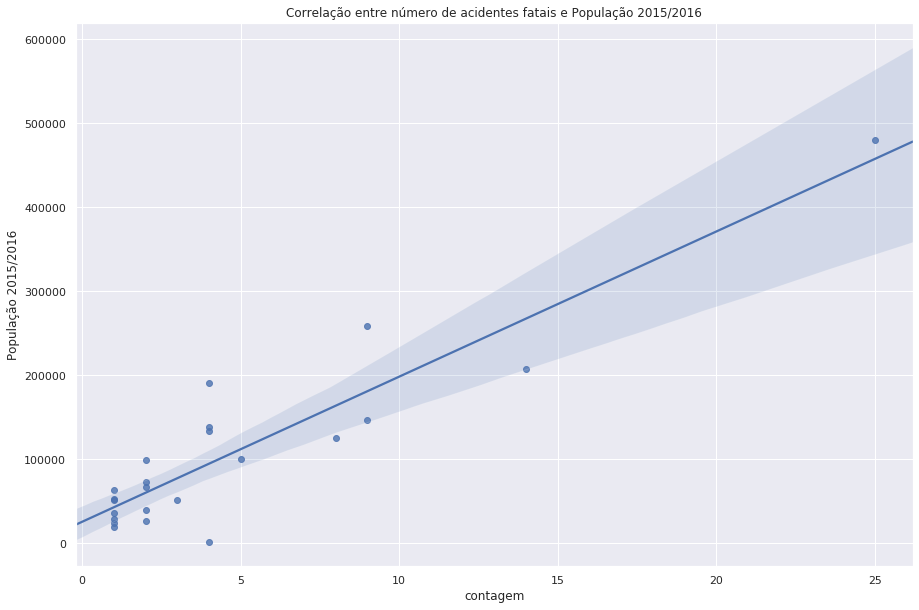

In [115]:
pearson_corr_demografia_acidentes('População 2015/2016')

Valor da correlação: -0.3568240448794187


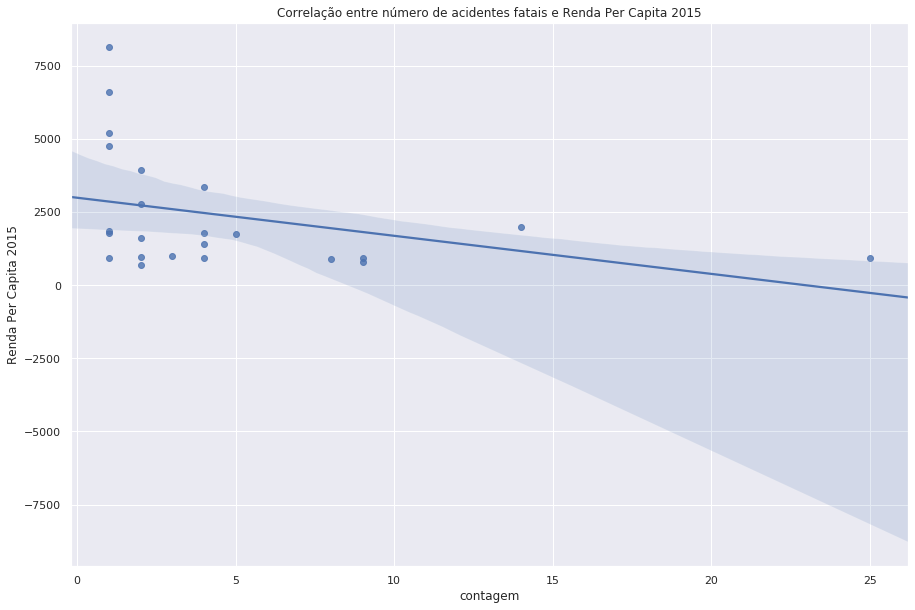

In [116]:
pearson_corr_demografia_acidentes('Renda Per Capita 2015')

Valor da correlação: 0.2949743131325557


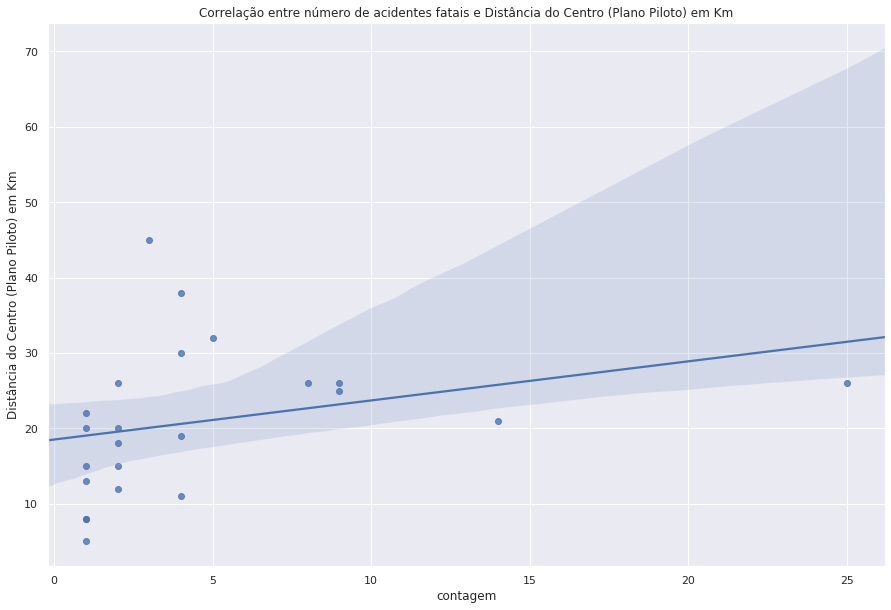

In [117]:
pearson_corr_demografia_acidentes('Distância do Centro (Plano Piloto) em Km')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

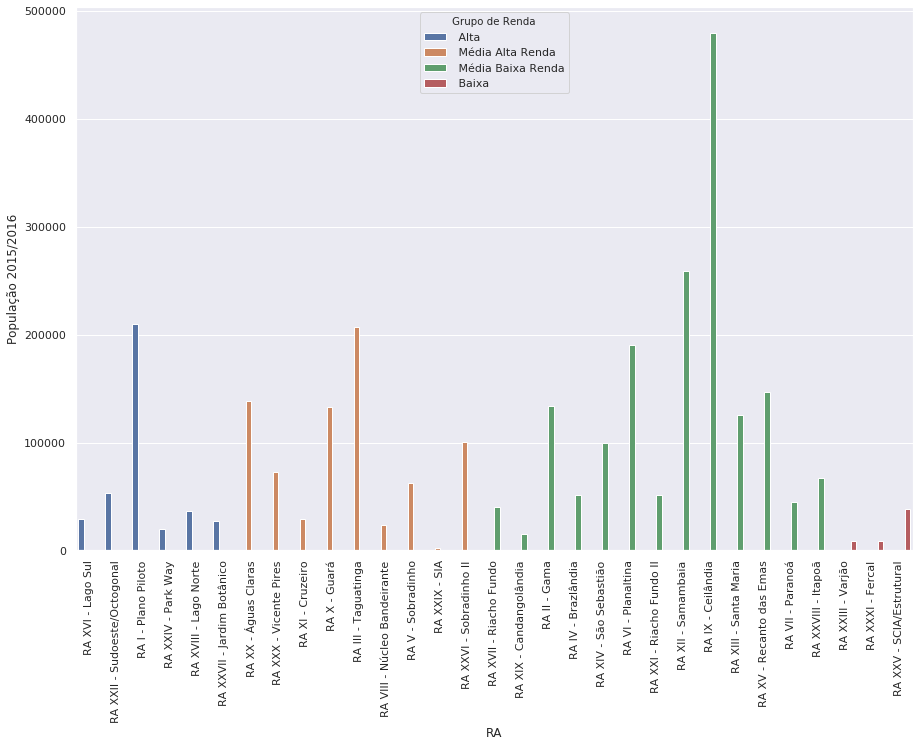

In [108]:
regioes_por_renda = df_demografia_2015_2016.groupby(['RA', 'Renda Per Capita 2015', 'Grupo de Renda', 'População 2015/2016']).size().reset_index().sort_values('Renda Per Capita 2015', ascending = False)
regioes_por_renda
sns.barplot(x = 'RA', y = 'População 2015/2016', hue = 'Grupo de Renda', data = regioes_por_renda)
plt.xticks(rotation = 90)

### Observações

* O número Total de sinalização (somando tipos de sinalização horizontal e vertical) por si só não apresenta resultados significantes em relação ao número de vítimas fatais, visto que as cidades com maiores índices ainda são as que apresentam o maior número de acidentes.
* Brasília (Plano Piloto) apresenta um índice muito elevado quando comparado as outras regiões.
* O valor da densidade de sinalização (calculada através da divisão pelo tamanho em área da região em ha) mostra que as cidades com maiores índices de sinalização por área estão de fato no grupo de cidades com menores índices de acidentes com vítimas fatais.
* Quase todas as regiões com maiores índices de sinalização por área estão no grupo de média-alta/alta renda, com exceção de candagolândia, varjão e riacho fundo (segundo censo 2015/2016) 

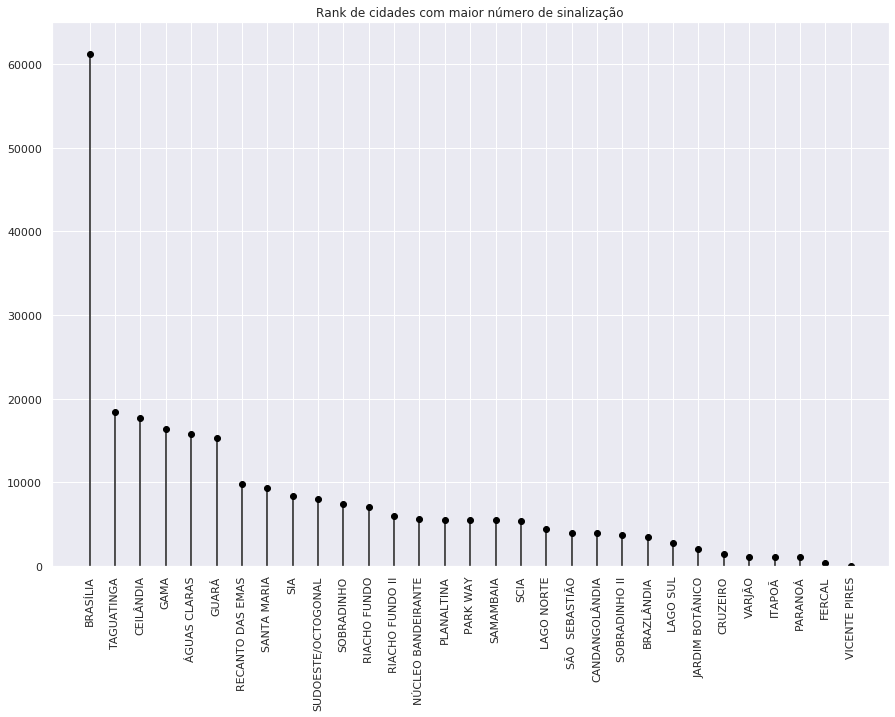

In [38]:
sinalizacao_2018 = df_sinalizacao_2018.groupby(['Região Administrativa', 'Horizontal', 'Vertical']).size().reset_index()
sinalizacao_2018 = sinalizacao_2018[sinalizacao_2018['Região Administrativa'] != 'TOTAL']
sinalizacao_2018.Horizontal = sinalizacao_2018.Horizontal.astype(str).str.replace(',', '.')
sinalizacao_2018.Horizontal = sinalizacao_2018.Horizontal.astype(float).astype(int)
sinalizacao_2018 = sinalizacao_2018.drop(0, axis = 1)
sinalizacao_2018 = sinalizacao_2018.sort_values(['Horizontal', 'Vertical'], ascending = False)
sinalizacao_2018['Total'] = sinalizacao_2018['Horizontal'] + sinalizacao_2018['Vertical']

fig, ax = plt.subplots()
ax.vlines(sinalizacao_2018['Região Administrativa'], ymin = 16, ymax = sinalizacao_2018.Horizontal)
ax.plot(sinalizacao_2018['Região Administrativa'], sinalizacao_2018.Horizontal, "o", color = 'black')
ax.set_ylim(0, 65000)
plt.xticks(rotation = 90)
plt.title('Rank de cidades com maior número de sinalização')
plt.show()

In [19]:
df_demografia = df_demografia_2015_2016
cidades = df_demografia.RA.str.split(' - ', n = 1, expand = True)
df_demografia.RA = cidades[1]
df_demografia.RA = df_demografia.RA.str.upper()

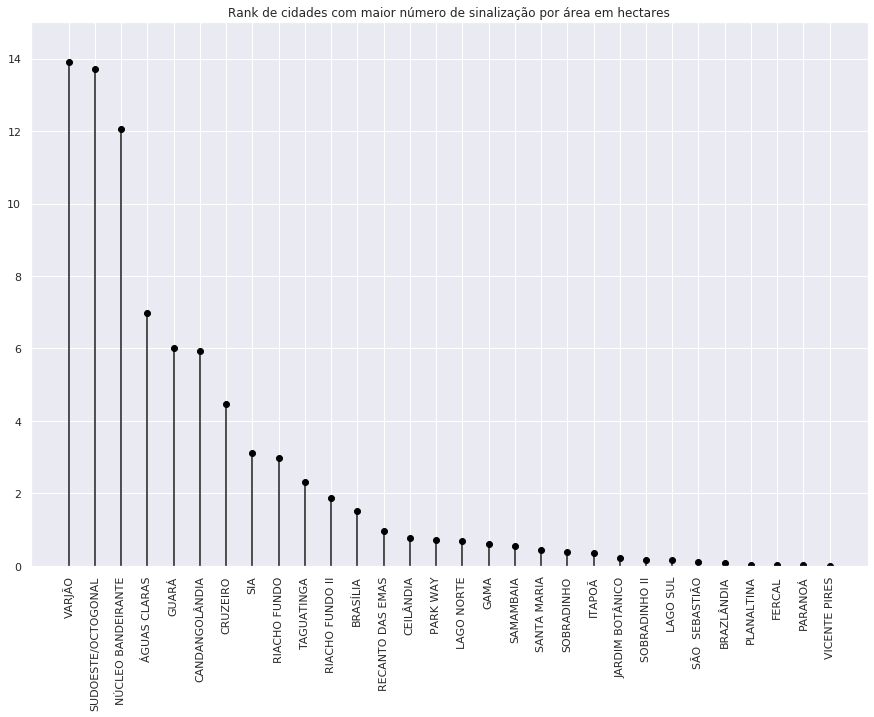

In [43]:
dct = {'PLANO PILOTO': 'BRASÍLIA', 'SÃO SEBASTIÃO': 'SÃO  SEBASTIÃO'}
df_demografia = df_demografia.replace(dct)
df_demografia

sinalizacao_por_area = pd.merge(sinalizacao_2018, df_demografia, left_on = 'Região Administrativa', right_on = 'RA')
sinalizacao_por_area
sinalizacao_por_area['Sinalizacao por área (ha)'] = sinalizacao_por_area['Total'] / sinalizacao_por_area['Área Total da RA (em ha)']
sinalizacao_por_area = sinalizacao_por_area.sort_values(['Sinalizacao por área (ha)'], ascending = False)

fig, ax = plt.subplots()
ax.vlines(sinalizacao_por_area['Região Administrativa'], ymin = 0, ymax = sinalizacao_por_area['Sinalizacao por área (ha)'])
ax.plot(sinalizacao_por_area['Região Administrativa'], sinalizacao_por_area['Sinalizacao por área (ha)'], "o", color = 'black')
ax.set_ylim(0, 15)
plt.xticks(rotation = 90)
plt.title('Rank de cidades com maior número de sinalização por área em hectares')
plt.show()

Text(0.5, 1.0, 'Regiões com maior número de acidentes fatais')

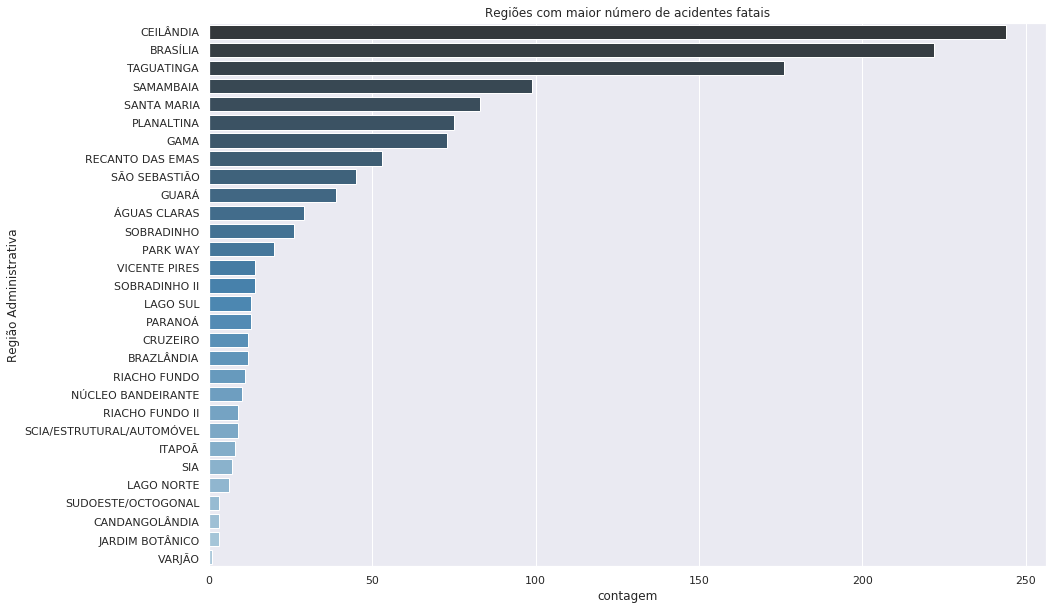

In [39]:
df_acidentes_fatais_2008_2017['Ano'] = df_acidentes_fatais_2008_2017['Ano'].astype(int)

acidentes_fatais_por_regiao = df_acidentes_fatais_2008_2017.groupby('Região Administrativa').size().reset_index(name = 'contagem')
acidentes_fatais_por_regiao = acidentes_fatais_por_regiao.sort_values('contagem', ascending = False)
contagem = acidentes_fatais_por_regiao['contagem']
regioes = acidentes_fatais_por_regiao['Região Administrativa']

sns.barplot(x = contagem, y = regioes, data = acidentes_fatais_por_regiao, palette = "Blues_d")
plt.title('Regiões com maior número de acidentes fatais')

### Observações

* O gráfico de ranking evidencia quatro diferentes rodovias do df com um número elevado de acidentes, sendo a EPNB, EPCT, EPIA e EPTG
* Infrações relacionadas ao uso de celular estão entre os 5 principais tipos de infração em quase todas as rodovias (exeto EPNB) no último ano.
* A EPNB é a rodovia com maior número de infrações, sendo a responsável por dar continuidade à EPIA, que é responsável por ligar regiões centrais importantes como o parque nacional de Brasília, eixo monumental (centro do Plano piloto) e SIA.
    * Os ônibus que passam pela rodovia saem de outras cidades com grandes índices de população, acidentes fatais e infrações, como Ceilândia, Taguatinga e Samambaia.
    * Os principais tipos de infrações na região são invasão da faixa lateral dos ônibus e excesso de velocidade (20%).
* A segunda rodovia com maior número de infrações é a EPCT, sendo esta a rodovia mais extensa do DF.
    * O anel viário passa por regiões importantes de Brasília como o jardim botânico, lago paranoá e Jardim Botânico.
    * Maior parte localizada em Taguatinga, região extensa e populosa entre as 5 com maiores números de acidentes.
    * Apesar de possuir trecho cercado por bares e comércio os principais tipos de infração registrados são relacionados à excesso de velocidade, uso de cinto de segurança e defeitos nos veículos, apresentando um número alto de infrações relacionadas ao uso do celular.
* A EPIA serve diversas outras rodovias, mantendo fora da cidade o trânsito de veículos pesados como caminhões (por ligar as saídas sul e norte).
    * Dos 5 principais tipos de infrações, 2 estão relacionados à utilização do celular.
    * Principais infrações são excesso de velocidade e defeitos nos veículos.
* EPTG é mais uma via que liga grandes regiões ao centro de Brasília, passando pelas RAs com maiores índices de acidentes e infrações.
    * Principais infrações estão relacionadas ao excesso de velocidade, trânsito na faixa esquerda e utilização de celular.
* Dados sustentam a premissa de que as rodovias que ligam as cidades ao centro de Brasília são de fato as mais movimentadas, com maiores índices de acidentes e infrações.
* Cidades com menos vias rápidas possuem maior densidade de sinalização e "mapas" que aparentam limitar o desenvolvimento  de altas velocidades.
* focar próximas observações em 2 rodovias no máximo.
    

##### Limpeza para identificação do local das infrações a partir da descrição do endereço

In [42]:
def recupera_ids_rodovias():
    df_infracoes_der_2018_2019_ra = df_infracoes_der_2018_2019
    df_infracoes_der_2018_2019_ra.auinf_local_rodovia = df_infracoes_der_2018_2019_ra.auinf_local_rodovia.astype(str)

    lista_rodovias = []

    for rodovia in df_infracoes_der_2018_2019_ra.auinf_local_rodovia:
        lista_rodovias.append(rodovia)

    lista_ids_rodovias = [(wrap(id_rodovia, 10)[0]).upper().strip().replace(' ', '-') for id_rodovia in lista_rodovias]
    lista_ids_rodovias = [wrap(id_rodovia, 6)[0] for id_rodovia in lista_ids_rodovias]

    df_infracoes_der_2018_2019_ra['ID rodovia'] = lista_ids_rodovias
    df_infracoes_der_2018_2019_ra['descricao'] = df_infracoes_der_2018_2019_ra['descricao'].str.strip()
    
    return df_infracoes_der_2018_2019_ra

In [10]:
df_infracoes_der_2018_2019_ra = recupera_ids_rodovias()

In [6]:
dict_ids_rodovias = {'DF-075': 'DF-075 (EPNB)',
                     'DF-001': 'DF-001 (EPCT)',
                     'DF-003': 'DF-003 (EPIA)',
                     'DF-085': 'DF-085 (EPTG)',
                     'DF-025': 'DF-025 (EPDB)',
                     'DF-095': 'DF-095 (EPCL)',
                     'DF-079': 'DF-079 (EPVP)',
                     'DF-005': 'DF-005 (EPPR)',
                     'DF-011': 'DF-011 (EPIG)'}

Text(0.5, 1.0, 'Rodovias do DF com maior número de infrações (DADOS DER) 2018-2019')

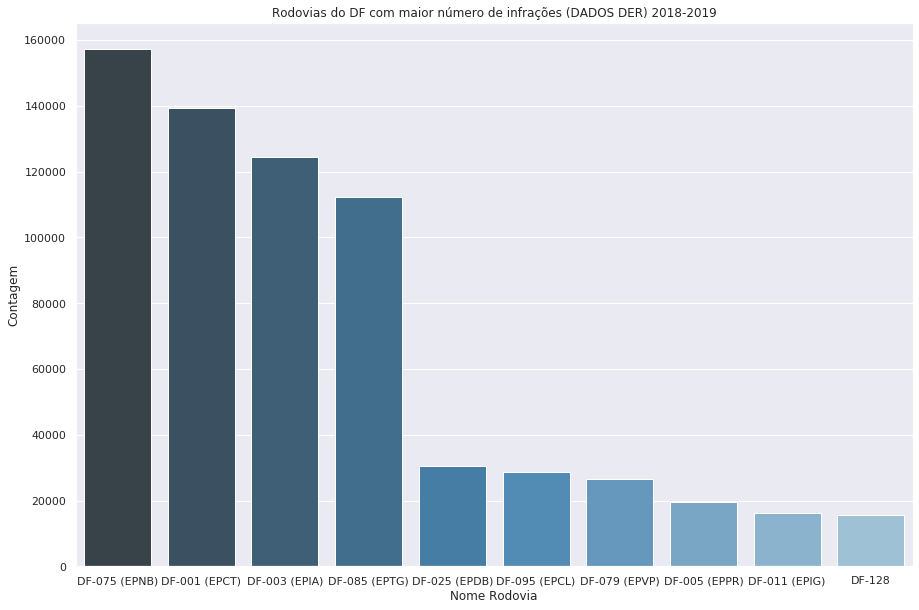

In [7]:
infracoes_por_rodovia = df_infracoes_der_2018_2019_ra['ID rodovia'].value_counts().reset_index(name = 'contagem')
infracoes_por_rodovia.columns = ['Nome Rodovia', 'Contagem']
infracoes_por_rodovia = infracoes_por_rodovia[~infracoes_por_rodovia['Nome Rodovia'].str.contains(" |V|\t")]
infracoes_por_rodovia = infracoes_por_rodovia[infracoes_por_rodovia['Nome Rodovia'].str.contains("DF")]
infracoes_por_rodovia = infracoes_por_rodovia.head(n = 10)

infracoes_por_rodovia = infracoes_por_rodovia.replace(dict_ids_rodovias)

sns.barplot(x = infracoes_por_rodovia['Nome Rodovia'], y = infracoes_por_rodovia['Contagem'], data = infracoes_por_rodovia, palette = "Blues_d")
plt.title("Rodovias do DF com maior número de infrações (DADOS DER) 2018-2019")

In [62]:
lista_principais_rodovias = ['DF-075 (EPNB)', 'DF-001 (EPCT)', 'DF-003 (EPIA)', 'DF-085 (EPTG)', 'DF-025 (EPDB)', 'DF-095 (EPCL)', 'DF-079 (EPVP)', 'DF-005 (EPPR)', 'DF-011 (EPIG)']

tipos_infracoes = df_infracoes_der_2018_2019_ra.groupby(['ID rodovia', 'descricao']).size().unstack().reset_index()
tipos_infracoes = tipos_infracoes[~tipos_infracoes['ID rodovia'].str.contains(" |V|\t")]
tipos_infracoes = tipos_infracoes[tipos_infracoes['ID rodovia'].str.contains("DF")]
tipos_infracoes = tipos_infracoes.melt(id_vars = ['ID rodovia'], value_vars = tipos_infracoes.columns[1:].to_list())
tipos_infracoes = tipos_infracoes.replace(dict_ids_rodovias)
tipos_infracoes = tipos_infracoes[tipos_infracoes.value >= 50]

def grafico_tipos_infracao(nome_rodovia):

    temp_df = tipos_infracoes[tipos_infracoes['ID rodovia'] == nome_rodovia]
    temp_df = temp_df.sort_values('value', ascending = False)
    
    lista_descricoes = [wrap(descricao, 70)[0] + '...' for descricao in temp_df.descricao]
    temp_df.descricao = lista_descricoes

    plt.figure()
    sns.barplot(data = temp_df, x = 'value', y = 'descricao', palette = "Blues_d", ci = None).set_title('Tipos de infrações na rodovia ' + nome_rodovia)
    plt.xticks(rotation = 90)

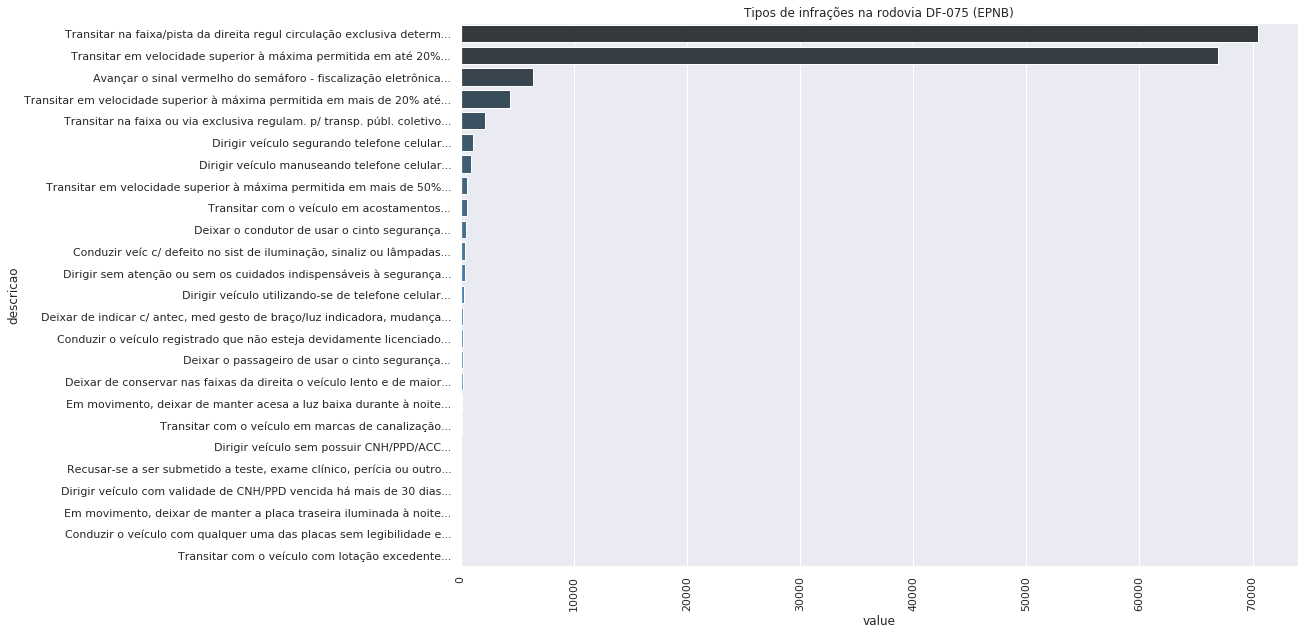

In [58]:
grafico_tipos_infracao('DF-075 (EPNB)')

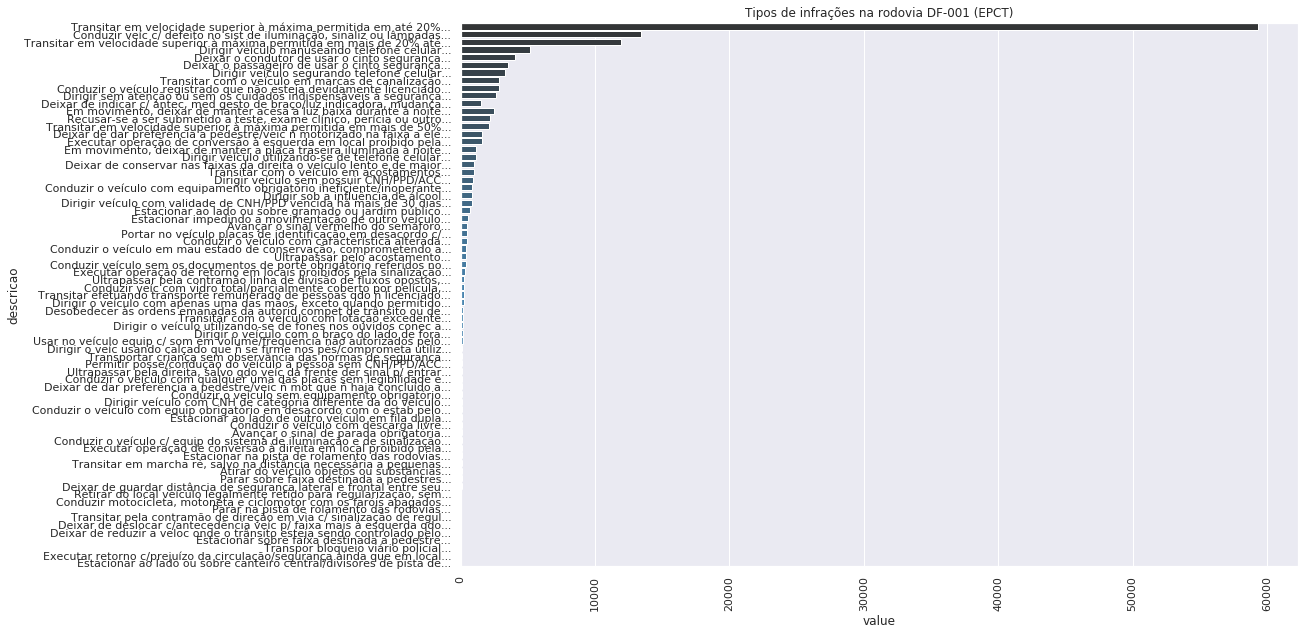

In [59]:
grafico_tipos_infracao('DF-001 (EPCT)')

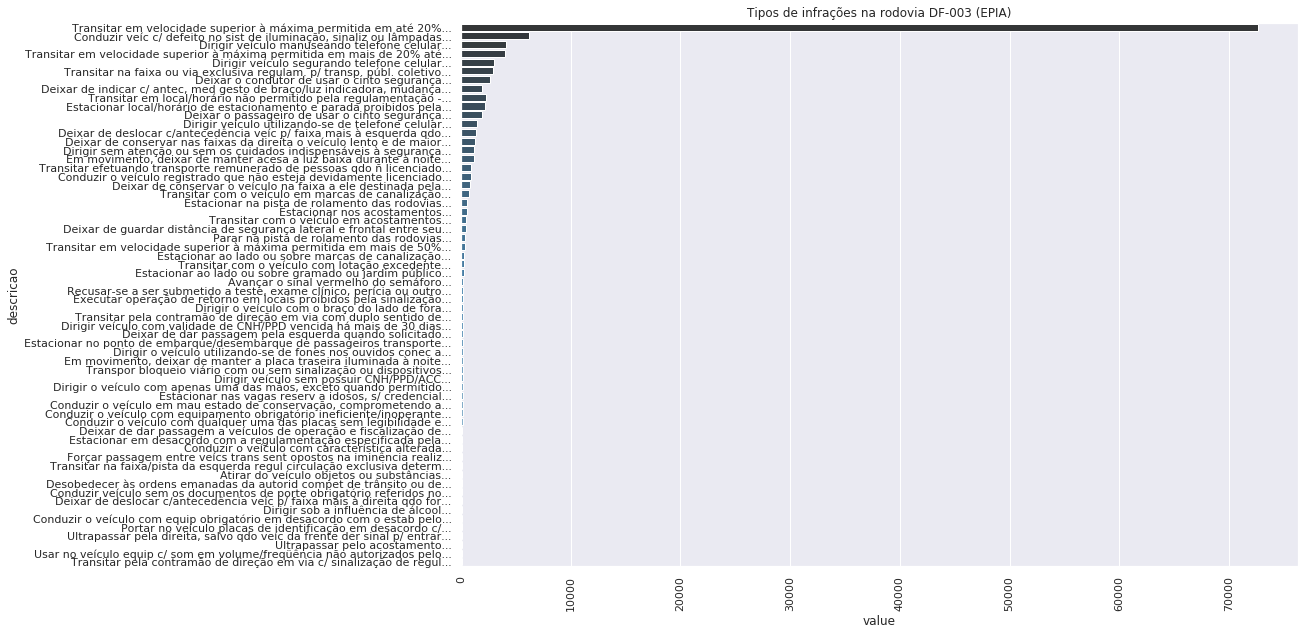

In [60]:
grafico_tipos_infracao('DF-003 (EPIA)')

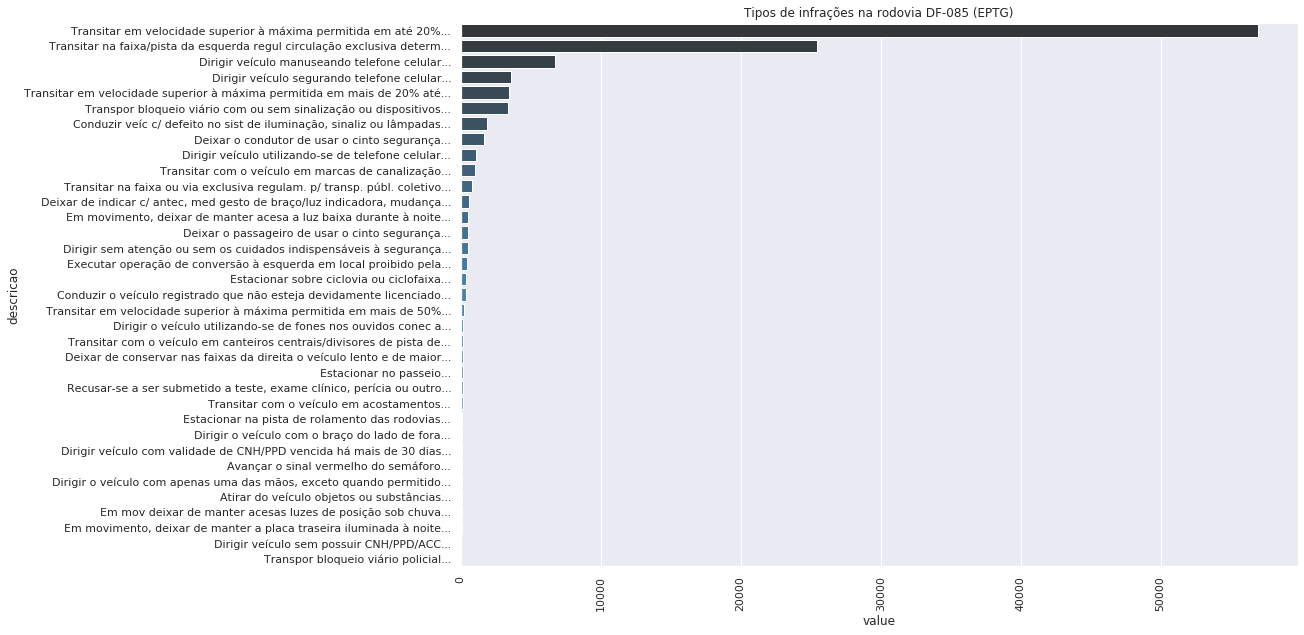

In [61]:
grafico_tipos_infracao('DF-085 (EPTG)')

### Observações Rodovias

* É possível visualizar 3 clusters com números semelhantes de acidentes
* BR 020 apresenta um número elevado de acidentes (focar devido as extensões das outras rodovias não estarem no df)
* A BR 450 que está inteiramente localizada dentro do DF e possui uma extensão menor (37 km) ainda assim possui um número alto de acidentes quando comparada com acidentes na BR 080 (742 km) e BR 251 (1515 km) (focar)
* BR 450 é concomitante com a EPIA
* BR 450 é uma das rodovias de ligação ao centro
* Número de acidentes com feridos aumenta apesar dos outros tipos diminuírem
* O maior tipo de ocorrência é de acidentes sem vítimas
* Período dos acidentes nos registros está incorreto
* A maior parte dos acidentes da BR 450 ocorre durante o período da noite e nos intervalos de pico após a tarde
* Acidentes se concentram nos finais e começo de semana
* Durante os intervalos de acidentes registrados na BR 450 não guardar distância segura provocou mais acidentes do que a ingestão de álcool
* Baixo índice de acidentes com vítimas fatais pode ser explicado por estarem fora da jurisdição da prf
* Ausência de registros a partir do ano de 2016 podem ser explicados por trechos deixarem de estar sob jurisdição da prf ou não atualização das bases de dados
* Pesquisa descritiva

Text(0.5, 1.0, 'Número de acidentes nas rodovias do DF')

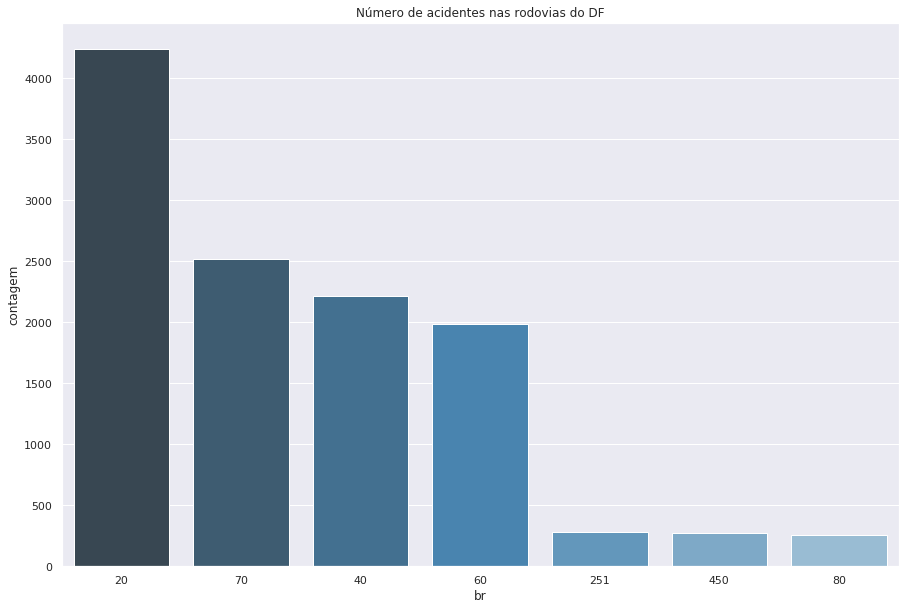

In [104]:
acidentes_por_rodovias = df_acidentes_rodovias_2010_2019

acidentes_por_rodovias = acidentes_por_rodovias.dropna()
acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(int)
acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 1]
acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 400]
acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(str)
acidentes_por_rodovias = acidentes_por_rodovias.groupby(['br']).size().reset_index(name = 'contagem')

order_lst = acidentes_por_rodovias.sort_values('contagem', ascending = False).br.tolist()
sns.barplot(data = acidentes_por_rodovias, x = 'br', y = 'contagem', palette = "Blues_d", ci = None, order = order_lst)
plt.title('Número de acidentes nas rodovias do DF')

In [44]:
acidentes_por_rodovias = df_acidentes_rodovias_2010_2019

acidentes_por_rodovias = acidentes_por_rodovias.dropna()
acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(int)
acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 1]
acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 400]
acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(str)

acidentes_br_450 = acidentes_por_rodovias[acidentes_por_rodovias.br == '450']
acidentes_br_450.fase_dia = acidentes_br_450.fase_dia.str.strip()
acidentes_br_450.dia_semana = acidentes_br_450.dia_semana.str.strip()
acidentes_br_450.horario = acidentes_br_450.horario.str.strip()

acidentes_br_450

,data_inversa,dia_semana,horario,uf,br,km,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,uso_solo,ano,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
874,2012-01-03,Terça,19:10:00,DF,450,33,Falta de atenção,Colisão traseira,Sem Vítimas,Anoitecer,...,Urbano,2012,2,0,0,0,2,0,0,2
879,2012-01-01,Domingo,15:30:00,DF,450,35.7,Falta de atenção,Colisão lateral,Sem Vítimas,Pleno dia,...,Urbano,2012,2,0,0,0,2,0,0,2
887,2012-01-01,Domingo,03:30:00,DF,450,34,Outras,Saída de Pista,Com Vítimas Feridas,Plena noite,...,Urbano,2012,1,0,1,0,0,0,1,1
898,2012-01-09,Segunda,19:00:00,DF,450,32,Falta de atenção,Colisão lateral,Sem Vítimas,Pleno dia,...,Rural,2012,2,0,0,0,2,0,0,2
942,2012-01-19,Quinta,18:35:00,DF,450,36,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Pleno dia,...,Urbano,2012,2,0,0,0,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11689,2011-09-26,Segunda,17:40:00,DF,450,34,Falta de atenção,Colisão lateral,Sem Vítimas,Anoitecer,...,Urbano,2011,3,0,0,0,3,0,0,3
11691,2011-03-10,Segunda,12:52:00,DF,450,36,Falta de atenção,Colisão traseira,Sem Vítimas,Pleno dia,...,Urbano,2011,3,0,0,0,3,0,0,2
11734,2011-04-10,Terça,21:00:00,DF,450,35,Outras,Colisão lateral,Com Vítimas Feridas,Plena noite,...,Urbano,2011,3,0,2,0,1,0,2,2
11740,2011-10-17,Segunda,12:25:00,DF,450,35,Falta de atenção,Colisão Transversal,Com Vítimas Feridas,Pleno dia,...,Rural,2011,2,0,1,0,1,0,1,2


Text(0.5, 1.0, 'Acidentes Registrados na BR 450')

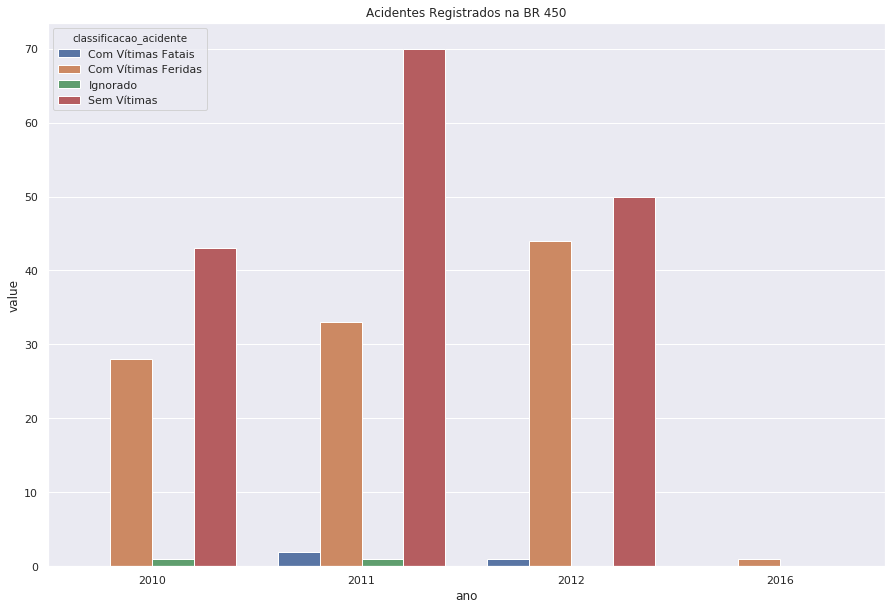

In [12]:
acidentes_450_ano = acidentes_br_450.groupby(['ano', 'classificacao_acidente']).size().unstack().reset_index()
acidentes_450_ano = pd.melt(acidentes_450_ano, id_vars = ['ano'], value_vars = acidentes_450_ano.columns[1:].tolist())
acidentes_450_ano.dropna()

sns.barplot(data = acidentes_450_ano, x = 'ano', y = 'value', hue = 'classificacao_acidente')
plt.title("Acidentes Registrados na BR 450")

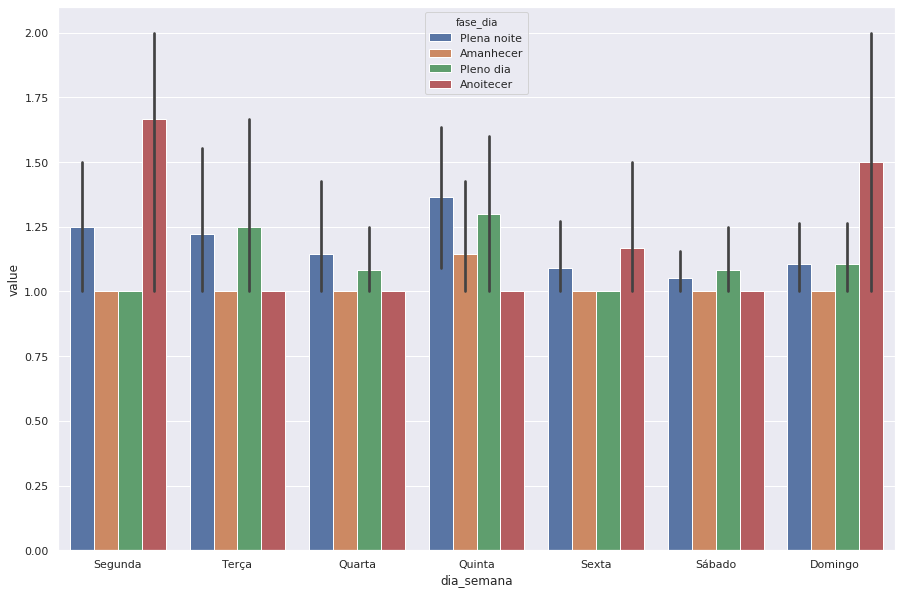

In [45]:
def get_periodo(row):
    if row['horario'] >= '06' and row['horario'] < '12':
        return 'Amanhecer'
    if row['horario'] >= '12' and row['horario'] < '18':
        return 'Pleno dia'
    if row['horario'] >= '18' and row['horario'] <= '19':
        return 'Anoitecer'
    else:
        return 'Plena noite'
    

acidentes_br_450_horario = acidentes_br_450.groupby(['dia_semana', 'horario']).size().unstack().reset_index()
acidentes_br_450_horario = pd.melt(acidentes_br_450_horario, id_vars = ['dia_semana'], value_vars = acidentes_br_450_horario.columns[1:].tolist())
acidentes_br_450_horario = acidentes_br_450_horario.dropna()
acidentes_br_450_horario['fase_dia'] = acidentes_br_450_horario.apply(lambda row: get_periodo(row), axis = 1)
acidentes_br_450_horario[acidentes_br_450_horario.fase_dia == 'Anoitecer']
dias_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']

sns.barplot(data = acidentes_br_450_horario, x = 'dia_semana', y = 'value', hue = 'fase_dia', order = dias_semana)

In [66]:
acidentes_br_450.causa_acidente.value_counts().rename_axis('Causas de acidentes').reset_index(name = 'contagem')

,Causas de acidentes,contagem
0,Falta de atenção,145
1,Outras,60
2,Não guardar distância de segurança,22
3,Ingestão de álcool,19
4,Defeito mecânico em veículo,9
5,Desobediência à sinalização,8
6,Dormindo,6
7,Velocidade incompatível,3
8,Ultrapassagem indevida,2


In [67]:
acidentes_br_450.classificacao_acidente.value_counts().rename_axis('Tipos de Acidentes na br 450').reset_index(name = 'contagem')

,Tipos de Acidentes na br 450,contagem
0,Sem Vítimas,163
1,Com Vítimas Feridas,106
2,Com Vítimas Fatais,3
3,Ignorado,2


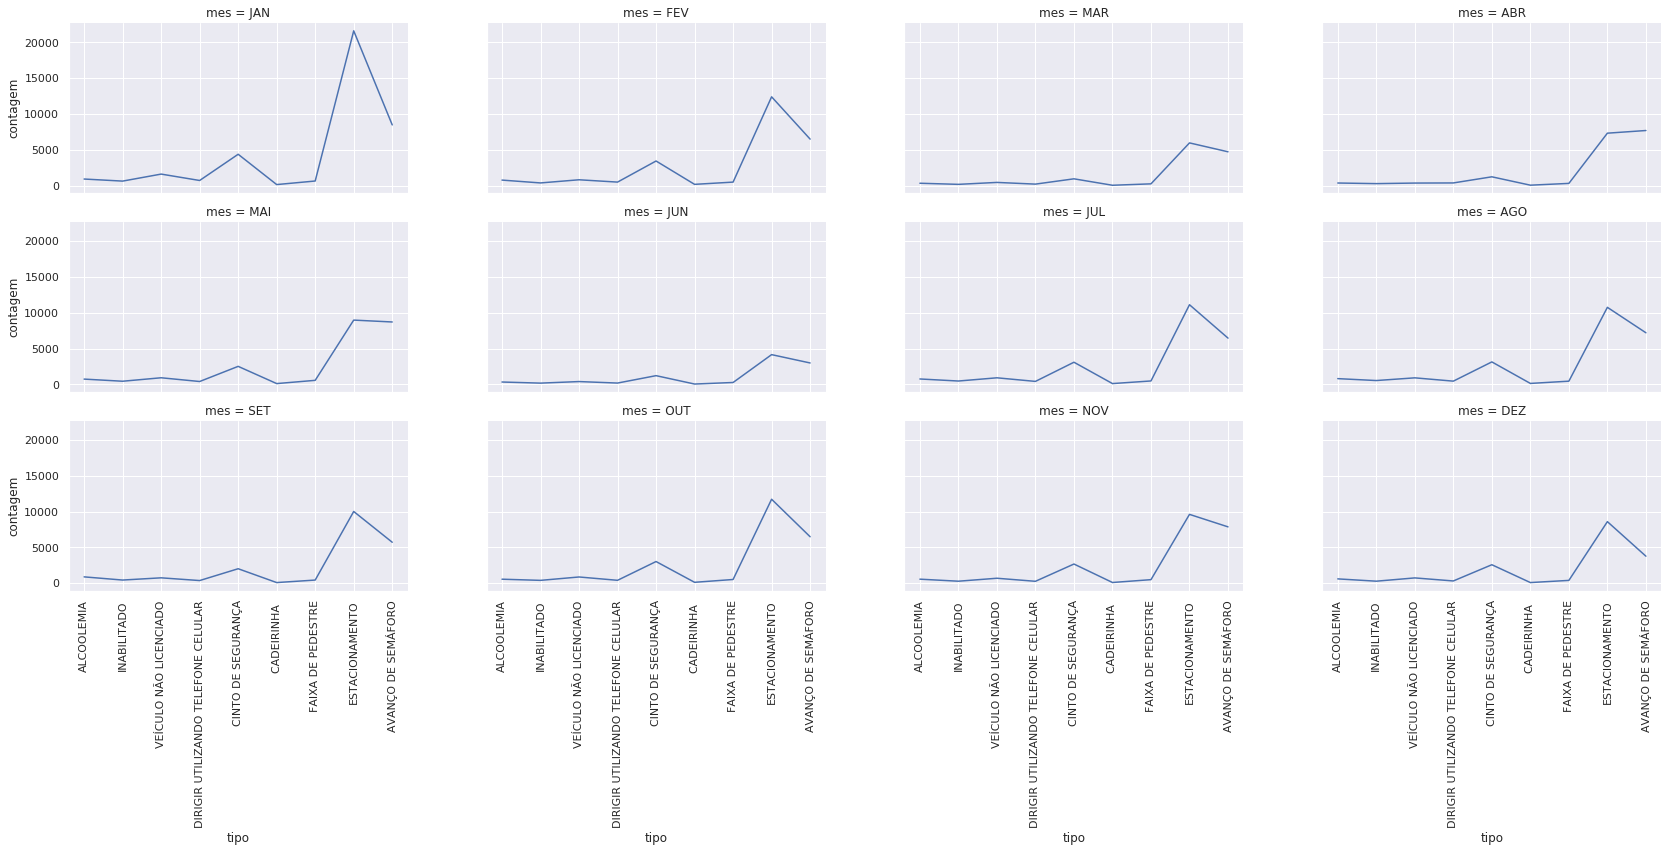

In [11]:
ordem_meses = df_tipos_infracoes_2018.columns[1:].tolist()
temp_df = pd.melt(df_tipos_infracoes_2018, id_vars = ['TIPO DE INFRACAO'], value_vars = ordem_meses)
temp_df.columns = ['tipo', 'mes', 'contagem']

grid = sns.FacetGrid(temp_df, col = 'mes', col_wrap = 4, aspect = 2)
grid.map(plt.plot, 'tipo', 'contagem')

for ax in grid.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)